# Text classification task: Bag of Words Cross Validation

Cross-validating Random Forest and NNs on the stemmed(+ "badowrds" removal) description which previously proves to better perform with tf-idf and count representations

## TL;DR 



## Packages

In [1]:
#---- magic trio + special guest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#---- utils
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from tqdm.autonotebook import tqdm
import time

/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_pickle("../data/df_preprocessed_eng_remap.pckle")

df.head()

,description,event_id,category,category_label,lang,lang_reliab,desc_stemm,desc_lemm,desc_stemm_no_badwords,desc_lemm_no_badwords,remap_category,remap_category_label
0,"<p><span>Hey explorersssss, what's up?</span><...",239719250,language/ethnic identity,15,English,99,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,language/ethnic identity,11
1,"<p>Free, unauditioned, collaborative pop choir...",gpjktmywhbnb,music,18,English,99,sing us free unaudit collabor pop choir identi...,sing u free unauditioned collaborative pop cho...,sing us unaudit collabor pop choir identifi wo...,sing u unauditioned collaborative pop choir id...,music,13
2,"<p>We provide a forum to learn about, promote ...",drrtzmywhbgb,career/business,3,English,98,east valley busi network meetup provid forum l...,east valley business network meetup provide fo...,east valley busi network provid forum learn pr...,east valley business network provide forum lea...,career/business,1
3,<p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...,239719229,socializing,27,English,92,friendli friday whynot japan meetup collabor e...,friendly friday whynot japan meetup collaborat...,friendli whynot japan collabor whynot japan si...,friendly whynot japan collaboration whynot jap...,socializing,20
4,<p>This is an introductory meeting to get to k...,mtzxwmywjbjb,tech,30,English,99,authent option introductori meet get know fell...,authentication option introductory meet get kn...,authent option introductori get fellow coder s...,authentication option introductory get fellow ...,tech,22


# Text representation 

In [3]:
tf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = None, norm = 'l1',ngram_range = (1,1),#unigrams
                                        preprocessor = None, max_features = 5000, sublinear_tf = True)

X_data_tf = tf_vectorizer.fit_transform(df.desc_stemm_no_badwords)

count_vect = CountVectorizer(max_features = 5000, analyzer = 'word', ngram_range = (1,1))

X_data_count = count_vect.fit_transform(df.desc_lemm_no_badwords)

In [4]:
print(X_data_tf.getnnz())
density = X_data_tf.getnnz() / np.prod(X_data_tf.shape)
print("density", round(density*100, 2) , "%")

6802987
density 1.13 %


In [5]:
print(X_data_count.getnnz())
density = X_data_count.getnnz() / np.prod(X_data_count.shape)
print("density", round(density*100, 2) , "%")

6685148
density 1.11 %


# 5 Folds CV

## Random Forest

In [10]:
%%time

#----- cross-validation cicle
k = 5
acc_cvscores = []
f1_w_cvscores = []
f1_m_cvscores = []
top_acc_cvscores = []

y_data = df.remap_category_label.values
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42).split(X_data_tf, y_data)


for train_idx, test_idx in folds:
    X_train_cv = X_data_tf[train_idx]
    #print(np.isnan(X_train_cv.toarray()).any())
    y_train_cv = y_data[train_idx]
    #print(np.isnan(y_train_cv).any())
    X_test_cv = X_data_tf[test_idx]
    y_test_cv = y_data[test_idx]

    rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
    rf = rf.fit(X_train_cv, y_train_cv)
    score = rf.score(X_test_cv, y_test_cv)
    acc_cvscores.append(score)
    y_pred = rf.predict(X_test_cv)
    f1_m_cvscores.append(sklearn.metrics.f1_score(y_test_cv, y_pred, average = "macro"))
    f1_w_cvscores.append(sklearn.metrics.f1_score(y_test_cv, y_pred, average = "weighted"))
    topn = np.argsort(rf.predict_proba(X_test_cv), axis = 1)[:,-3:]
    top_acc_cvscores.append(np.mean(np.array([1 if y_test_cv[k] in topn[k] else 0 for k in range(len(topn))])))
    
    print("acc_test: {}%".format(round(score, 4)))    

print("top_1_acc: {} (+/- {})\n".format(round(np.mean(acc_cvscores), 3), round(np.std(acc_cvscores), 3)))

print("top_3_acc: {} (+/- {})\n".format(round(np.mean(top_acc_cvscores), 3), round(np.std(top_acc_cvscores), 3)))

print("weighted F-Measure: {} (+/- {})\n".format(round(np.mean(f1_w_cvscores), 3), round(np.std(f1_w_cvscores), 3)))

print("macro F-Measure: {} (+/- {})\n".format(round(np.mean(f1_m_cvscores), 3), round(np.std(f1_m_cvscores), 3)))


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


acc_test: 0.6966%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


acc_test: 0.6986%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


acc_test: 0.6917%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


acc_test: 0.6883%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


acc_test: 0.6913%
top_1_acc: 0.693 (+/- 0.004)

top_3_acc: 0.865 (+/- 0.002)

weighted F-Measure: 0.689 (+/- 0.004)

macro F-Measure: 0.664 (+/- 0.005)

CPU times: user 2h 40min 11s, sys: 25.7 s, total: 2h 40min 36s
Wall time: 6min 26s
Parser   : 751 ms


In [12]:
%%time

#----- cross-validation cicle
k = 5
acc_cvscores = []
f1_w_cvscores = []
f1_m_cvscores = []
top_acc_cvscores = []

y_data = df.remap_category_label.values
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42).split(X_data_count, y_data)


for train_idx, test_idx in folds:
    X_train_cv = X_data_tf[train_idx]
    #print(np.isnan(X_train_cv.toarray()).any())
    y_train_cv = y_data[train_idx]
    #print(np.isnan(y_train_cv).any())
    X_test_cv = X_data_tf[test_idx]
    y_test_cv = y_data[test_idx]

    rf = RandomForestClassifier(n_estimators = 100, n_jobs=40,  verbose = 1)
    rf = rf.fit(X_train_cv, y_train_cv)
    score = rf.score(X_test_cv, y_test_cv)
    acc_cvscores.append(score)
    y_pred = rf.predict(X_test_cv)
    f1_m_cvscores.append(sklearn.metrics.f1_score(y_test_cv, y_pred, average = "macro"))
    f1_w_cvscores.append(sklearn.metrics.f1_score(y_test_cv, y_pred, average = "weighted"))
    topn = np.argsort(rf.predict_proba(X_test_cv), axis = 1)[:,-3:]
    top_acc_cvscores.append(np.mean(np.array([1 if y_test_cv[k] in topn[k] else 0 for k in range(len(topn))])))
    
    print("acc_test: {}%".format(round(score, 4)))    

print("top_1_acc: {} (+/- {})\n".format(round(np.mean(acc_cvscores), 3), round(np.std(acc_cvscores), 3)))

print("top_3_acc: {} (+/- {})\n".format(round(np.mean(top_acc_cvscores), 3), round(np.std(top_acc_cvscores), 3)))

print("weighted F-Measure: {} (+/- {})\n".format(round(np.mean(f1_w_cvscores), 3), round(np.std(f1_w_cvscores), 3)))

print("macro F-Measure: {} (+/- {})\n".format(round(np.mean(f1_m_cvscores), 3), round(np.std(f1_m_cvscores), 3)))


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


acc_test: 0.6961%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


acc_test: 0.6991%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


acc_test: 0.6902%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished


acc_test: 0.6895%


[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.2s finished


acc_test: 0.6916%
top_1_acc: 0.693 (+/- 0.004)

top_3_acc: 0.865 (+/- 0.002)

weighted F-Measure: 0.689 (+/- 0.004)

macro F-Measure: 0.663 (+/- 0.005)

CPU times: user 2h 37min 3s, sys: 24.5 s, total: 2h 37min 28s
Wall time: 6min 49s


## NN Classifier

In [42]:
from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import ReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l1_l2, l1, l2
from keras.optimizers import RMSprop, Nadam, SGD
import keras.backend as K
from keras.models import clone_model
from keras.utils import to_categorical, multi_gpu_model

from sklearn.preprocessing import LabelEncoder


!pip install livelossplot --upgrade --user

from livelossplot.keras import PlotLossesCallback

Requirement already up-to-date: livelossplot in /home/newuser/.local/lib/python3.6/site-packages
  Using cached https://files.pythonhosted.org/packages/b1/f1/0a67f09ef53a342403ffa66646ee39273e0ac79ffa5de5dbe2f3e28b5bdf/notebook-6.0.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4e/11/06958a2b895a3853206dea1fb2a5b11bf044f626f90745987612af9c8f2c/matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/79/6c/05a569e9f703d18aacb89b7ad6075b404e8a4afde2c26b73ca77bb644b14/nbconvert-5.6.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d7/62/d1a5d654b7a21bd3eb99be1b59a608cc18a7a08ed88495457a87c40a0495/ipykernel-5.1.4-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fb/82/86437f661875e30682e99d04c13ba6c216f86f5f6ca6ef212d3ee8b6ca11/jupyter_core-4.6.1-py2.py3-none-any.whl
Requirement already up-to-date: Send2Trash in /opt/intel/intelpython3/lib/python3.6/site-packages (fr

Requirement already up-to-date: attrs>=17.4.0 in /home/newuser/.local/lib/python3.6/site-packages (from jsonschema!=2.5.0,>=2.4->nbformat->notebook->livelossplot)
  Using cached https://files.pythonhosted.org/packages/c6/42/cb41a6b0cf27fff05e5caab37e254cf6a69442634f4c5d4a03f2d5cb12eb/parso-0.6.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/58/b4/4850a0ccc6f567cc0ebe7060d20ffd4258b8210efadc259da62dc6ed9c65/wcwidth-0.1.8-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/be/69/4ac28bf238f287f1677f41392e24d2c4ffafcf11648c23824f5f62ef6ccb/zipp-2.1.0-py3-none-any.whl
  Found existing installation: zipp 0.6.0
    Uninstalling zipp-0.6.0:
      Successfully uninstalled zipp-0.6.0
  Found existing installation: importlib-metadata 1.3.0
    Uninstalling importlib-metadata-1.3.0:
      Successfully uninstalled importlib-metadata-1.3.0
  Found existing installation: setuptools 42.0.2
    Uninstalling setuptools-42.0.2:
      Successfully uni

In [21]:
df.remap_category.unique().shape[0]

24

In [25]:
#-----
K.clear_session()

def make_model(X_data_tf, y_data):
    model = Sequential()
    model.add(Dense(1024, input_dim = X_data_tf.shape[1]))#, kernel_regularizer=l1_l2(0.0005, 0.0005)))
    model.add(ReLU())
    model.add(Dropout(.5))
    model.add(Dense(512))
    model.add(ReLU())
    model.add(Dropout(.5))
    model.add(Dense(128))
    model.add(ReLU())
    model.add(Dropout(.5))
    model.add(Dense(df.remap_category.unique().shape[0], activation="softmax"))
    model.summary()
    return model

model = make_model(X_data_tf, y_data)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              5121024   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
__________

In [26]:
#----- k-folds cross validation
def load_data_kfold(k, X_train, y_train):
    
    folds = list(StratifiedKFold(n_splits = k, shuffle = True,
                                 random_state = 42).split(X_train, y_train))
    
    return folds


In [56]:

#----- top-k accuracy score
def top_k_acc(model, X_test, y_true, k_top = 3, ml = False):
    if ml:
        probs = model.predict_proba(X_test)
    else:  
        probs = model.predict(X_test)
    #y_true = np.argmax(y_true, axis = 1)
    topn = np.argsort(probs, axis = 1)[:,-k:]
    return np.mean(np.array([1 if y_true[k_top] in topn[k_top] else 0 for k_top in range(len(topn))]))

0
Train on 86973 samples, validate on 9664 samples
Epoch 1/100
86973/86973 [==============================] - 11s 128us/step - loss: 2.9988 - acc: 0.1229 - val_loss: 2.8065 - val_acc: 0.2146
Epoch 2/100
86973/86973 [==============================] - 10s 113us/step - loss: 2.6674 - acc: 0.2162 - val_loss: 2.2551 - val_acc: 0.4078
Epoch 3/100
86973/86973 [==============================] - 10s 113us/step - loss: 2.0781 - acc: 0.4232 - val_loss: 1.7451 - val_acc: 0.5209
Epoch 4/100
86973/86973 [==============================] - 9s 108us/step - loss: 1.7310 - acc: 0.5281 - val_loss: 1.5401 - val_acc: 0.5786
Epoch 5/100
86973/86973 [==============================] - 10s 114us/step - loss: 1.5398 - acc: 0.5803 - val_loss: 1.4322 - val_acc: 0.6005
Epoch 6/100
86973/86973 [==============================] - 10s 116us/step - loss: 1.4102 - acc: 0.6121 - val_loss: 1.3519 - val_acc: 0.6277
Epoch 7/100
86973/86973 [==============================] - 10s 116us/step - loss: 1.3050 - acc: 0.6400 - val_l

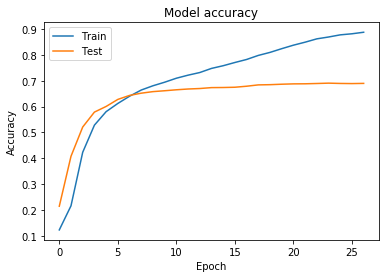

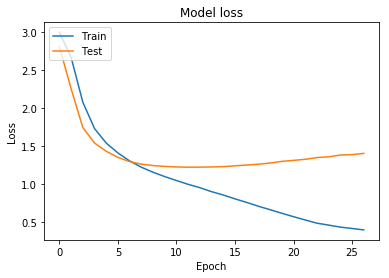

0.6908820122455734
1
Train on 86977 samples, validate on 9665 samples
Epoch 1/100
86977/86977 [==============================] - 12s 140us/step - loss: 2.9920 - acc: 0.1137 - val_loss: 2.7937 - val_acc: 0.1437
Epoch 2/100
86977/86977 [==============================] - 10s 119us/step - loss: 2.6021 - acc: 0.2340 - val_loss: 2.1754 - val_acc: 0.3926
Epoch 3/100
86977/86977 [==============================] - 10s 118us/step - loss: 2.0840 - acc: 0.3841 - val_loss: 1.8086 - val_acc: 0.4922
Epoch 4/100
86977/86977 [==============================] - 10s 119us/step - loss: 1.7711 - acc: 0.5048 - val_loss: 1.5719 - val_acc: 0.5621
Epoch 5/100
86977/86977 [==============================] - 10s 116us/step - loss: 1.5631 - acc: 0.5687 - val_loss: 1.4536 - val_acc: 0.6012
Epoch 6/100
86977/86977 [==============================] - 10s 116us/step - loss: 1.4291 - acc: 0.6057 - val_loss: 1.3722 - val_acc: 0.6250
Epoch 7/100
86977/86977 [==============================] - 9s 106us/step - loss: 1.3322 - 

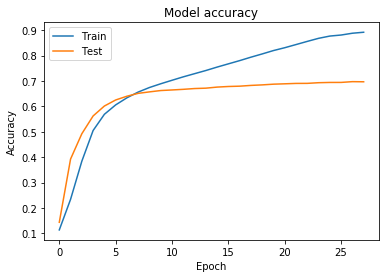

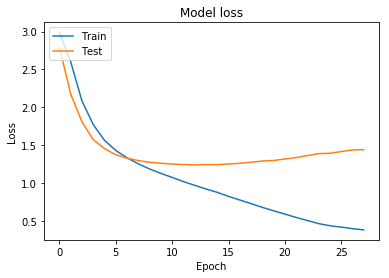

0.6967352174452767
2
Train on 86983 samples, validate on 9665 samples
Epoch 1/100
86983/86983 [==============================] - 12s 140us/step - loss: 2.9960 - acc: 0.1219 - val_loss: 2.7860 - val_acc: 0.1446
Epoch 2/100
86983/86983 [==============================] - 10s 119us/step - loss: 2.5757 - acc: 0.2580 - val_loss: 2.1218 - val_acc: 0.4173
Epoch 3/100
86983/86983 [==============================] - 10s 118us/step - loss: 1.9993 - acc: 0.4394 - val_loss: 1.7101 - val_acc: 0.5312
Epoch 4/100
86983/86983 [==============================] - 10s 119us/step - loss: 1.6927 - acc: 0.5362 - val_loss: 1.5320 - val_acc: 0.5689
Epoch 5/100
86983/86983 [==============================] - 10s 116us/step - loss: 1.5272 - acc: 0.5761 - val_loss: 1.4415 - val_acc: 0.5989
Epoch 6/100
86983/86983 [==============================] - 9s 108us/step - loss: 1.4051 - acc: 0.6130 - val_loss: 1.3687 - val_acc: 0.6193
Epoch 7/100
86983/86983 [==============================] - 10s 118us/step - loss: 1.3061 - 

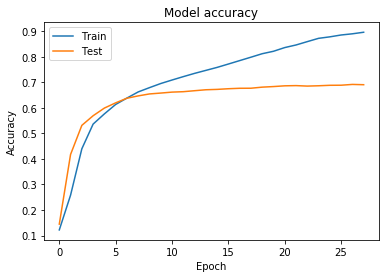

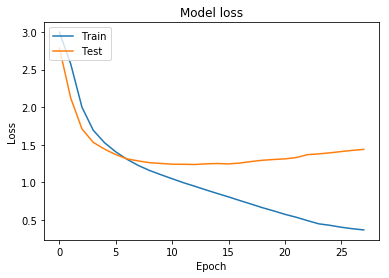

0.6919829477256736
3
Train on 86985 samples, validate on 9666 samples
Epoch 1/100
86985/86985 [==============================] - 11s 124us/step - loss: 2.9918 - acc: 0.1249 - val_loss: 2.7971 - val_acc: 0.1586
Epoch 2/100
86985/86985 [==============================] - 9s 102us/step - loss: 2.6098 - acc: 0.2333 - val_loss: 2.1664 - val_acc: 0.3913
Epoch 3/100
86985/86985 [==============================] - 9s 101us/step - loss: 2.0248 - acc: 0.4213 - val_loss: 1.7457 - val_acc: 0.5187
Epoch 4/100
86985/86985 [==============================] - 9s 100us/step - loss: 1.7153 - acc: 0.5228 - val_loss: 1.5643 - val_acc: 0.5654
Epoch 5/100
86985/86985 [==============================] - 9s 101us/step - loss: 1.5460 - acc: 0.5732 - val_loss: 1.4638 - val_acc: 0.5935
Epoch 6/100
86985/86985 [==============================] - 9s 100us/step - loss: 1.4299 - acc: 0.6068 - val_loss: 1.3832 - val_acc: 0.6191
Epoch 7/100
86985/86985 [==============================] - 9s 101us/step - loss: 1.3256 - acc: 

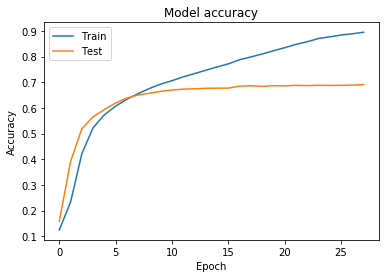

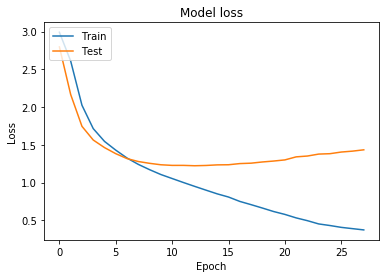

0.6896680188757347
4
Train on 86992 samples, validate on 9666 samples
Epoch 1/100
86992/86992 [==============================] - 11s 124us/step - loss: 2.9832 - acc: 0.1267 - val_loss: 2.7869 - val_acc: 0.2022
Epoch 2/100
86992/86992 [==============================] - 9s 102us/step - loss: 2.5686 - acc: 0.2650 - val_loss: 2.1064 - val_acc: 0.4080
Epoch 3/100
86992/86992 [==============================] - 9s 100us/step - loss: 2.0023 - acc: 0.4337 - val_loss: 1.7294 - val_acc: 0.5270
Epoch 4/100
86992/86992 [==============================] - 9s 101us/step - loss: 1.7151 - acc: 0.5259 - val_loss: 1.5407 - val_acc: 0.5735
Epoch 5/100
86992/86992 [==============================] - 9s 100us/step - loss: 1.5329 - acc: 0.5768 - val_loss: 1.4364 - val_acc: 0.6042
Epoch 6/100
86992/86992 [==============================] - 9s 102us/step - loss: 1.4098 - acc: 0.6114 - val_loss: 1.3584 - val_acc: 0.6338
Epoch 7/100
86992/86992 [==============================] - 9s 101us/step - loss: 1.3052 - acc: 

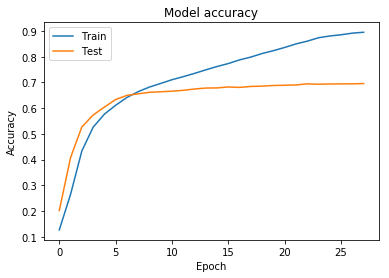

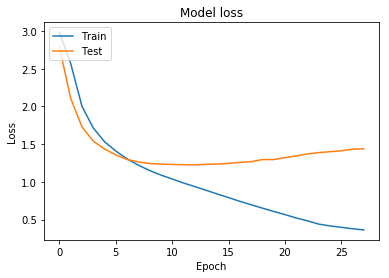

0.6902405697486647
Acc: 0.692 (+/- 0.003)
Top-3: 0.908 (+/- 0.001)
F1-Macro: 0.671 (+/- 0.003)
F1-Weighted: 0.691 (+/- 0.003)


In [59]:
#----- cross-validation cicle

k = 5
cvscores = []
cvscores_val = []

f1_macro = []
f1_weighted = []
acc = []
top_3 = []

lb = LabelEncoder()
lb.fit(df.remap_category)

y_data = df.remap_category.values

folds = load_data_kfold(k, X_data_tf, y_data)
for j, (train_idx, test_idx) in enumerate(folds):
    print(j)
    es = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = False, verbose = 1)
    rlrop = ReduceLROnPlateau(monitor='val_loss', patience = 10, factor = .5, min_lr = 1e-6, verbose = 1)
    X_train_cv = X_data_tf[train_idx]
    y_train_cv = y_data[train_idx]
    X_test_cv = X_data_tf[test_idx]
    y_test_cv = y_data[test_idx]

    y_train_cv = lb.transform(y_train_cv)
    y_test_cv = lb.transform(y_test_cv)
    y_train_cv = to_categorical(y_train_cv, num_classes = 24)
    y_test_cv = to_categorical(y_test_cv, num_classes = 24)


    #----- creation of validation set for EarlyStopping
    X_train_cv, X_val, y_train_cv, y_val = train_test_split(X_train_cv, y_train_cv, test_size = .1,
                                                       random_state = 42,
                                                       stratify = y_train_cv)
    kfold_model = clone_model(model)
    #kfold_model = multi_gpu_model(kfold_model, gpus=2)
    kfold_model.compile(optimizer = Adam(), loss = "categorical_crossentropy", metrics = ['acc'])

    history = kfold_model.fit(X_train_cv, y_train_cv,
                   batch_size = 2*2048,
                   epochs = 100,
                   verbose = 1,
                   validation_data = (X_val, y_val),
                   callbacks = [es, rlrop])
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    #----- evaluation
    y_pred = kfold_model.predict_classes(X_test_cv)
    y_true = np.argmax(y_test_cv, axis = 1)
    f1_macro.append(sklearn.metrics.f1_score(y_true, y_pred, average = 'macro'))
    f1_weighted.append(sklearn.metrics.f1_score(y_true, y_pred, average = 'weighted'))
    acc.append(sklearn.metrics.accuracy_score(y_true, y_pred))
    top_3.append(top_k_acc(kfold_model, X_test_cv, y_true, k_top = 3))
    
    print(acc[j])
    
    
print("Acc: {} (+/- {})\nTop-3: {} (+/- {})\nF1-Macro: {} (+/- {})\nF1-Weighted: {} (+/- {})".format(round(np.mean(acc), 3), round(np.std(acc), 3),
                          round(np.mean(top_3), 3), round(np.std(top_3), 3),
                          round(np.mean(f1_macro), 3), round(np.std(f1_macro), 3),
                          round(np.mean(f1_weighted), 3), round(np.std(f1_weighted), 3)))

    

#print("acc_test: {}% (+/- {}%)  acc_val: {}% (+/- {}%)\n".format(round(np.mean(cvscores), 2), round(np.std(cvscores), 2), round(np.mean(cvscores_val), 2), round(np.std(cvscores_val), 2)))

0
Train on 86973 samples, validate on 9664 samples
Epoch 1/100
86973/86973 [==============================] - 11s 122us/step - loss: 2.9892 - acc: 0.1220 - val_loss: 2.7923 - val_acc: 0.2778
Epoch 2/100
86973/86973 [==============================] - 9s 100us/step - loss: 2.5928 - acc: 0.2534 - val_loss: 2.1429 - val_acc: 0.3804
Epoch 3/100
86973/86973 [==============================] - 9s 100us/step - loss: 2.0322 - acc: 0.4184 - val_loss: 1.7416 - val_acc: 0.5144
Epoch 4/100
86973/86973 [==============================] - 9s 102us/step - loss: 1.7195 - acc: 0.5240 - val_loss: 1.5444 - val_acc: 0.5723
Epoch 5/100
86973/86973 [==============================] - 9s 100us/step - loss: 1.5419 - acc: 0.5725 - val_loss: 1.4514 - val_acc: 0.5940
Epoch 6/100
86973/86973 [==============================] - 9s 101us/step - loss: 1.4251 - acc: 0.6064 - val_loss: 1.3874 - val_acc: 0.6198
Epoch 7/100
86973/86973 [==============================] - 9s 101us/step - loss: 1.3321 - acc: 0.6334 - val_loss: 

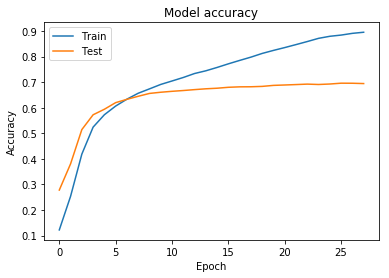

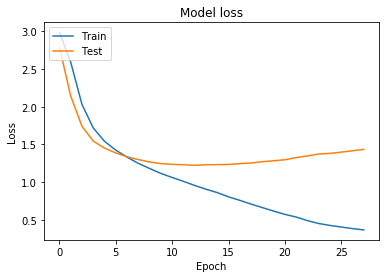

0.6946880688399801
1
Train on 86977 samples, validate on 9665 samples
Epoch 1/100
86977/86977 [==============================] - 11s 126us/step - loss: 2.9806 - acc: 0.1207 - val_loss: 2.7840 - val_acc: 0.2023
Epoch 2/100
86977/86977 [==============================] - 9s 102us/step - loss: 2.5828 - acc: 0.2444 - val_loss: 2.1723 - val_acc: 0.4023
Epoch 3/100
86977/86977 [==============================] - 9s 101us/step - loss: 2.0298 - acc: 0.4274 - val_loss: 1.7247 - val_acc: 0.5166
Epoch 4/100
86977/86977 [==============================] - 9s 102us/step - loss: 1.7140 - acc: 0.5290 - val_loss: 1.5487 - val_acc: 0.5701
Epoch 5/100
86977/86977 [==============================] - 9s 102us/step - loss: 1.5432 - acc: 0.5760 - val_loss: 1.4523 - val_acc: 0.5977
Epoch 6/100
86977/86977 [==============================] - 9s 102us/step - loss: 1.4217 - acc: 0.6072 - val_loss: 1.3803 - val_acc: 0.6217
Epoch 7/100
86977/86977 [==============================] - 9s 101us/step - loss: 1.3272 - acc: 

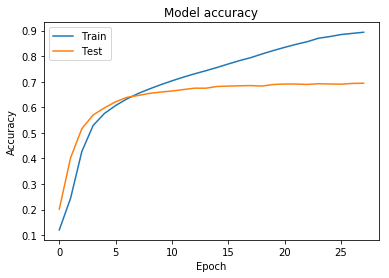

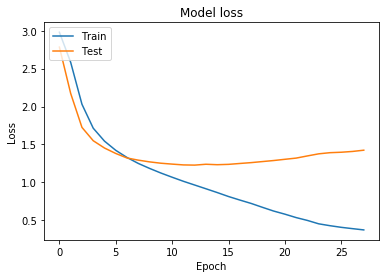

0.6963628087888443
2
Train on 86983 samples, validate on 9665 samples
Epoch 1/100
86983/86983 [==============================] - 11s 127us/step - loss: 2.9889 - acc: 0.1228 - val_loss: 2.8013 - val_acc: 0.1778
Epoch 2/100
86983/86983 [==============================] - 9s 100us/step - loss: 2.6159 - acc: 0.2410 - val_loss: 2.1663 - val_acc: 0.4244
Epoch 3/100
86983/86983 [==============================] - 9s 101us/step - loss: 2.0396 - acc: 0.4247 - val_loss: 1.7374 - val_acc: 0.5205
Epoch 4/100
86983/86983 [==============================] - 9s 103us/step - loss: 1.7233 - acc: 0.5258 - val_loss: 1.5472 - val_acc: 0.5669
Epoch 5/100
86983/86983 [==============================] - 9s 102us/step - loss: 1.5424 - acc: 0.5768 - val_loss: 1.4429 - val_acc: 0.5977
Epoch 6/100
86983/86983 [==============================] - 9s 103us/step - loss: 1.4135 - acc: 0.6148 - val_loss: 1.3654 - val_acc: 0.6236
Epoch 7/100
86983/86983 [==============================] - 9s 100us/step - loss: 1.3099 - acc: 

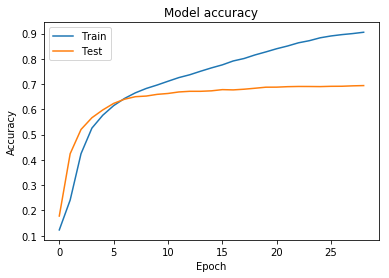

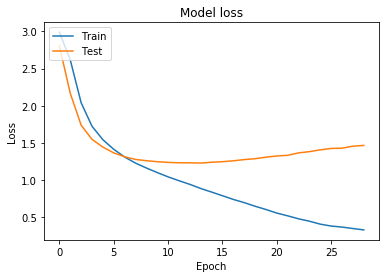

0.6932246181863333
3
Train on 86985 samples, validate on 9666 samples
Epoch 1/100
86985/86985 [==============================] - 11s 127us/step - loss: 2.9946 - acc: 0.1289 - val_loss: 2.7978 - val_acc: 0.2063
Epoch 2/100
86985/86985 [==============================] - 9s 102us/step - loss: 2.6194 - acc: 0.2410 - val_loss: 2.1740 - val_acc: 0.4060
Epoch 3/100
86985/86985 [==============================] - 9s 101us/step - loss: 2.0052 - acc: 0.4444 - val_loss: 1.7263 - val_acc: 0.5141
Epoch 4/100
86985/86985 [==============================] - 9s 103us/step - loss: 1.6995 - acc: 0.5332 - val_loss: 1.5492 - val_acc: 0.5679
Epoch 5/100
86985/86985 [==============================] - 9s 105us/step - loss: 1.5276 - acc: 0.5764 - val_loss: 1.4435 - val_acc: 0.5920
Epoch 6/100
86985/86985 [==============================] - 9s 106us/step - loss: 1.4084 - acc: 0.6104 - val_loss: 1.3591 - val_acc: 0.6291
Epoch 7/100
86985/86985 [==============================] - 9s 101us/step - loss: 1.3017 - acc: 

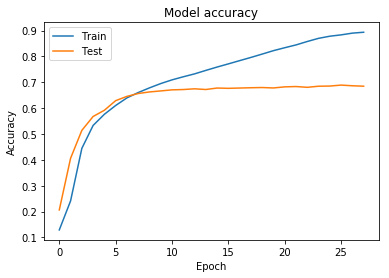

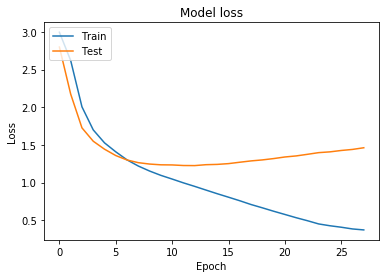

0.6909512376852388
4
Train on 86992 samples, validate on 9666 samples
Epoch 1/100
86992/86992 [==============================] - 11s 130us/step - loss: 2.9920 - acc: 0.1283 - val_loss: 2.7649 - val_acc: 0.1851
Epoch 2/100
86992/86992 [==============================] - 9s 106us/step - loss: 2.5252 - acc: 0.2663 - val_loss: 2.0897 - val_acc: 0.4028
Epoch 3/100
86992/86992 [==============================] - 9s 103us/step - loss: 1.9982 - acc: 0.4287 - val_loss: 1.7359 - val_acc: 0.5214
Epoch 4/100
86992/86992 [==============================] - 9s 104us/step - loss: 1.7072 - acc: 0.5263 - val_loss: 1.5421 - val_acc: 0.5745
Epoch 5/100
86992/86992 [==============================] - 9s 104us/step - loss: 1.5313 - acc: 0.5740 - val_loss: 1.4426 - val_acc: 0.5934
Epoch 6/100
86992/86992 [==============================] - 9s 106us/step - loss: 1.4148 - acc: 0.6068 - val_loss: 1.3678 - val_acc: 0.6267
Epoch 7/100
86992/86992 [==============================] - 9s 104us/step - loss: 1.3065 - acc: 

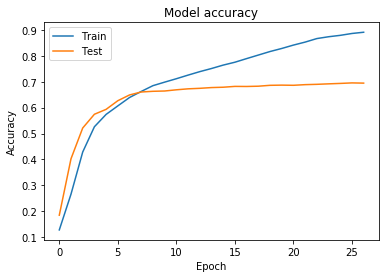

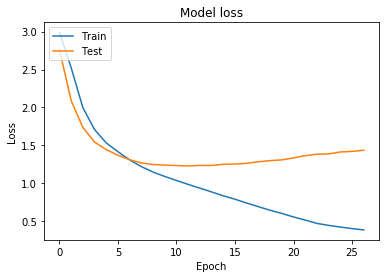

0.6910686928077512
Acc: 0.693 (+/- 0.002)
Top-3: 0.907 (+/- 0.001)
F1-Macro: 0.673 (+/- 0.004)
F1-Weighted: 0.693 (+/- 0.002)


In [60]:
#----- cross-validation cicle

k = 5
cvscores = []
cvscores_val = []

f1_macro = []
f1_weighted = []
acc = []
top_3 = []

lb = LabelEncoder()
lb.fit(df.remap_category)

y_data = df.remap_category.values

folds = load_data_kfold(k, X_data_count, y_data)
for j, (train_idx, test_idx) in enumerate(folds):
    print(j)
    es = EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = False, verbose = 1)
    rlrop = ReduceLROnPlateau(monitor='val_loss', patience = 10, factor = .5, min_lr = 1e-6, verbose = 1)
    X_train_cv = X_data_tf[train_idx]
    y_train_cv = y_data[train_idx]
    X_test_cv = X_data_tf[test_idx]
    y_test_cv = y_data[test_idx]

    y_train_cv = lb.transform(y_train_cv)
    y_test_cv = lb.transform(y_test_cv)
    y_train_cv = to_categorical(y_train_cv, num_classes = 24)
    y_test_cv = to_categorical(y_test_cv, num_classes = 24)


    #----- creation of validation set for EarlyStopping
    X_train_cv, X_val, y_train_cv, y_val = train_test_split(X_train_cv, y_train_cv, test_size = .1,
                                                       random_state = 42,
                                                       stratify = y_train_cv)
    kfold_model = clone_model(model)
    #kfold_model = multi_gpu_model(kfold_model, gpus=2)
    kfold_model.compile(optimizer = Adam(), loss = "categorical_crossentropy", metrics = ['acc'])

    history = kfold_model.fit(X_train_cv, y_train_cv,
                   batch_size = 2*2048,
                   epochs = 100,
                   verbose = 1,
                   validation_data = (X_val, y_val),
                   callbacks = [es, rlrop])
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    #----- evaluation
    y_pred = kfold_model.predict_classes(X_test_cv)
    y_true = np.argmax(y_test_cv, axis = 1)
    f1_macro.append(sklearn.metrics.f1_score(y_true, y_pred, average = 'macro'))
    f1_weighted.append(sklearn.metrics.f1_score(y_true, y_pred, average = 'weighted'))
    acc.append(sklearn.metrics.accuracy_score(y_true, y_pred))
    top_3.append(top_k_acc(kfold_model, X_test_cv, y_true, k_top = 3))
    
    print(acc[j])
    
    
print("Acc: {} (+/- {})\nTop-3: {} (+/- {})\nF1-Macro: {} (+/- {})\nF1-Weighted: {} (+/- {})".format(round(np.mean(acc), 3), round(np.std(acc), 3),
                          round(np.mean(top_3), 3), round(np.std(top_3), 3),
                          round(np.mean(f1_macro), 3), round(np.std(f1_macro), 3),
                          round(np.mean(f1_weighted), 3), round(np.std(f1_weighted), 3)))

    

#print("acc_test: {}% (+/- {}%)  acc_val: {}% (+/- {}%)\n".format(round(np.mean(cvscores), 2), round(np.std(cvscores), 2), round(np.mean(cvscores_val), 2), round(np.std(cvscores_val), 2)))